## Forex Market Analysis with MetaTrader 5



### Overview
This section of the notebook is dedicated to analyzing the Forex market using data from MetaTrader 5 (MT5). We focus on major currency pairs across different currencies like USD, EUR, GBP, and others. Our aim is to visualize the daily percentage change in these currency pairs.

### Data Retrieval and Processing
- **MT5 Connection:** We initiate a connection to MetaTrader 5 to access real-time currency pair data.
- **Currency Pairs:** We analyze a set of major currency pairs for each of the following currencies: USD, EUR, GBP, AUD, NZD, CAD, CHF, and JPY.
- **Data Fetching:** For each currency pair, we retrieve the current price and the opening price for the day. This data is used to calculate the daily percentage change.


In [3]:
# FUNCTIONS

from datetime import datetime, timedelta

def get_adjusted_day():
    """
    Returns the adjusted current day of the month.
    Adjusts the date for weekends.
    """
    day_of_week = datetime.now().isoweekday()  # 1 = Monday, 7 = Sunday

    # Adjust the date for weekends
    if day_of_week == 6:  # Saturday
        day = datetime.now() - timedelta(days=1)
    elif day_of_week == 7:  # Sunday
        day = datetime.now() - timedelta(days=2)
    else:
        day = datetime.now()

    # Extracting the day of the month
    day_of_month = day.day

    return day_of_month


In [4]:
# gather price data using the mt5 api
# https://www.mql5.com/en/docs/integration/python_metatrader5

import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta

# establish connection to the MetaTrader 5 terminal
mt5.initialize()

# connect to MetaTrader 5
if not mt5.initialize():
    print("initialize() failed, error code =", mt5.last_error())
    quit()
else:
    print("Connection to MT5 established")

# get the adjusted day of the month
day = get_adjusted_day()

# set time zone to UTC
timezone = pytz.timezone("Etc/UTC")
# create 'datetime' objects in UTC time zone to avoid the implementation of a local time zone offset
utc_from = datetime(2023, 12, day, tzinfo=timezone)
utc_to = datetime(2023, 12, day, hour=23, tzinfo=timezone)

# list of symbols to gather data for
symbol_list = ["USDCAD", "USDJPY", "USDCHF", "EURUSD", "GBPUSD", "AUDUSD", "NZDUSD"]

# create an empty dictionary to store the data for each symbol
# this dictionary will be used to create the comparison chart 
all_symbols_dict = {}
# create an empty DataFrame to store the current day's open and close prices for each symbol 
# this dataframe will be used to create the percentage change chart
day_change_df = pd.DataFrame()

# get the data for each symbol
for symbol in symbol_list:

    # get the data for the current day
    cur_daily_rate = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_D1, 0, 1)

    # get the data for the symbol
    rates = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_H1, utc_from, utc_to)
    
    # create a DataFrame with a column called symbol containing the symbol name and then add the data to it
    rates_frame = pd.DataFrame(cur_daily_rate)
    rates_frame['symbol'] = symbol
    # convert the time in seconds into the datetime format
    rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s') 
    # add the data the the day_change_df dataframe
    day_change_df = pd.concat([day_change_df, rates_frame], ignore_index=True)

    # create a DataFrame with a column called symbol containing the symbol name and then add the data to it
    rates_frame = pd.DataFrame(rates)
    # convert the time in seconds into the datetime format
    rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s') 
    # add the data the the day_change_df dataframe
    all_symbols_dict[symbol] = rates_frame

    
# shut down connection to the MetaTrader 5 terminal
print("Shutting down connection to MT5...")
mt5.shutdown()

print("\nDaily Change DataFrame for all symbols:")
display(day_change_df)
# display the combined dictionary for all symbols
print("\nKeys in the all_symbols_dict dictionary:")
display(all_symbols_dict.keys())

Connection to MT5 established
Shutting down connection to MT5...

Daily Change DataFrame for all symbols:


,time,open,high,low,close,tick_volume,spread,real_volume,symbol
0,2023-12-15,1.34068,1.34155,1.33506,1.33758,120740,0,0,USDCAD
1,2023-12-15,141.85000,142.46700,141.42800,142.16500,164143,0,0,USDJPY
2,2023-12-15,0.86740,0.87114,0.86521,0.87017,148380,0,0,USDCHF
3,2023-12-15,1.09923,1.10038,1.08868,1.08953,157194,0,0,EURUSD
4,2023-12-15,1.27664,1.27908,1.26684,1.26746,151790,0,0,GBPUSD
5,2023-12-15,0.66977,0.67284,0.66630,0.67020,111951,0,0,AUDUSD
6,2023-12-15,0.62055,0.62294,0.61780,0.62091,96015,0,0,NZDUSD



Keys in the all_symbols_dict dictionary:


dict_keys(['USDCAD', 'USDJPY', 'USDCHF', 'EURUSD', 'GBPUSD', 'AUDUSD', 'NZDUSD'])

In [5]:
# preparing the Daily Change DataFrame for plotting
# keep only the columns we need which are time, symbol, open and close
day_change_df = day_change_df[['time', 'symbol', 'open', 'close']]
# create a new column called 'change' and calculate the difference between the open and close prices
day_change_df['pct_change'] = (day_change_df['close'] - day_change_df['open']) / day_change_df['open'] * 100


### Visualization
- **Bar Charts:** We use bar charts to represent the daily change in percentage for each currency pair. Positive changes are shown in green, while negative changes are in red.
- **Subplots for Each Currency:** The notebook creates a separate subplot for each currency, displaying its respective major pairs and their daily changes.
- **Customization:** The visualization is customized with a dark background style, and the x-ticks are rotated for better readability.

## Creating a Multi-Bar Plot

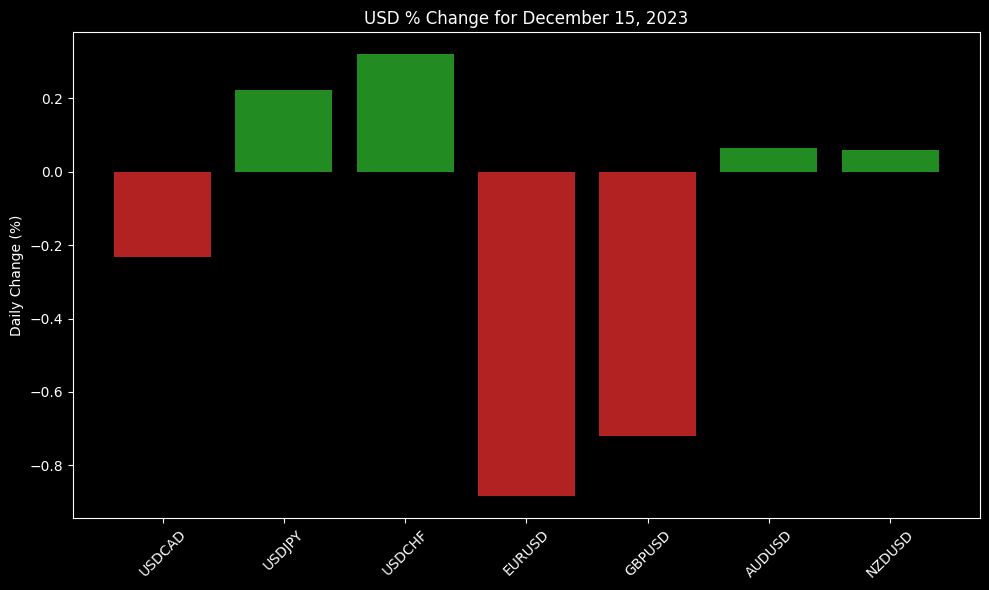

In [6]:
import matplotlib.pyplot as plt

# set the style of the plots
plt.style.use('dark_background')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Width of a bar
bar_width = 0.8

# Plot each symbol's percentage change as a bar
for i, symbol in enumerate(symbol_list):
    # Get the data for the current symbol
    symbol_df = day_change_df[day_change_df['symbol'] == symbol]
    # Assuming there's only one entry per symbol in the DataFrame
    pct_change = symbol_df['pct_change'].iloc[0]
    # Plot the data as a bar
    ax.bar(i, pct_change, bar_width, label=symbol, color='#228B22' if pct_change > 0 else '#b22222')

# Set title and labels for axes
ax.set(xlabel="",
       ylabel="Daily Change (%)",
       title=f"USD % Change for {day_change_df['time'].iloc[0].strftime('%B %d, %Y')}")

# Set the x-ticks to be the symbols
ax.set_xticks(range(len(symbol_list)))
ax.set_xticklabels(symbol_list)


# Rotate the x-axis labels
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
# Display the plot
plt.show()


## Plotting the Multi Plot Currency Pairs Chart

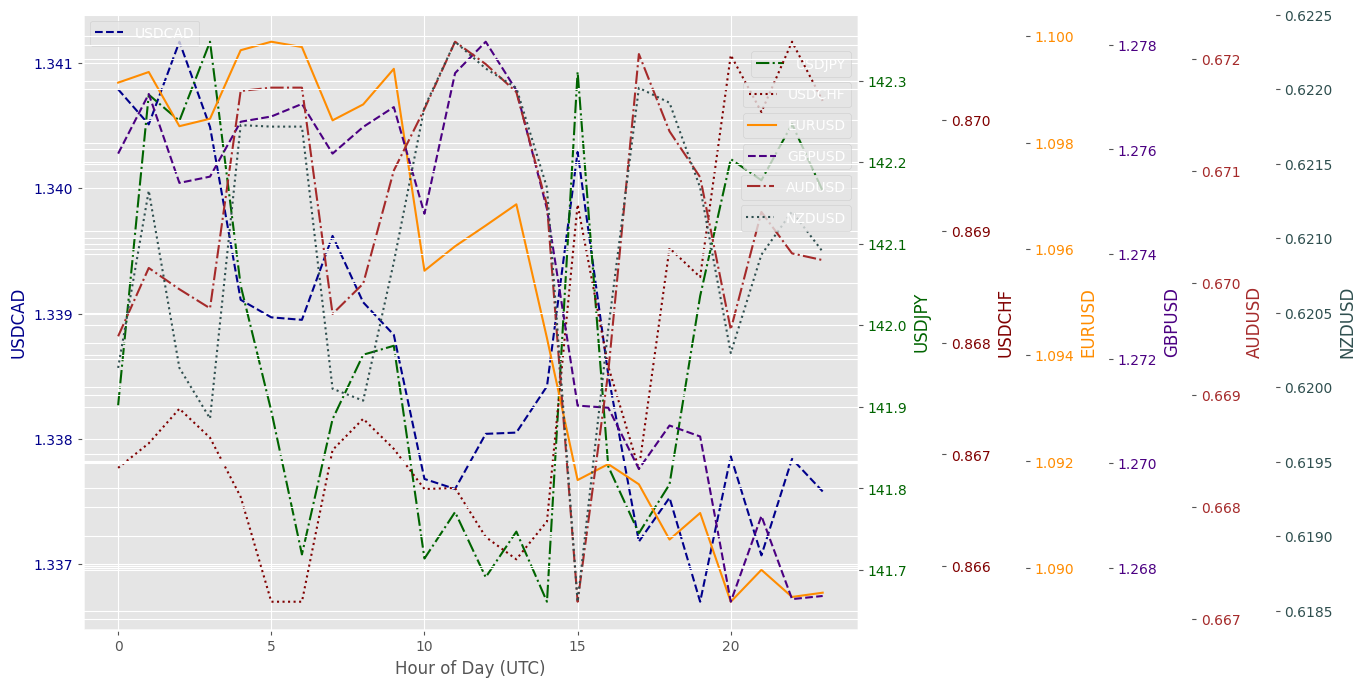

In [7]:
import matplotlib.pyplot as plt

# Assuming all_symbols_dict is your data dictionary with keys as symbol names
symbols = list(all_symbols_dict.keys())  # List of symbols
colors = ['darkblue', 'darkgreen', 'maroon', 'darkorange', 'indigo', 'brown', 'darkslategray']
line_styles = ['--', '-.', ':', '-', '--', '-.', ':']  # Different line styles for differentiation

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 8))

# Loop through the symbols and plot on respective axes
for i, symbol in enumerate(symbols):
    if i == 0:
        # First symbol on the primary axis
        ax.plot(all_symbols_dict[symbol]["close"], label=symbol, color=colors[i], linestyle=line_styles[i])
        ax.set_ylabel(symbol, color=colors[i])
        ax.tick_params(axis='y', labelcolor=colors[i])
    else:
        # Subsequent symbols on twin axes
        ax_new = ax.twinx()
        ax_new.plot(all_symbols_dict[symbol]["close"], label=symbol, color=colors[i], linestyle=line_styles[i])
        ax_new.spines['right'].set_position(('outward', 60 * (i-1)))
        ax_new.set_ylabel(symbol, color=colors[i])
        ax_new.tick_params(axis='y', labelcolor=colors[i])
        ax_new.legend(loc='upper right', bbox_to_anchor=(1, 1 - 0.05 * i))

ax.set_xlabel('Hour of Day (UTC)')
ax.legend(loc='upper left')

plt.show()


### Conclusion
This visualization provides a quick and informative snapshot of the current market dynamics in the Forex market, allowing traders and analysts to spot trends and make informed decisions.


# Bonus Chart - Markets as a whole

## Creating a Bar Chart for the Major Currency Markets

This project demonstrates the process of connecting to MetaTrader 5, fetching forex data, processing it, and visualizing the results using Matplotlib.

## Process Overview

1. **Initialization of MetaTrader 5**
   Establishing a connection with the MetaTrader 5 terminal to access forex market data.

2. **Data Gathering and Processing**
   Utilizing pandas and numpy for efficient data handling and calculations.

3. **Visualization with Matplotlib**
   Creating subplots for each currency to analyze daily changes in the forex market.

4. **Final Output**
   A comprehensive chart showcasing the analysis results with multiple currency subplots.

5. **MT5 Shutdown**
   Safely terminating the connection to the MetaTrader 5 terminal after data processing and visualization.




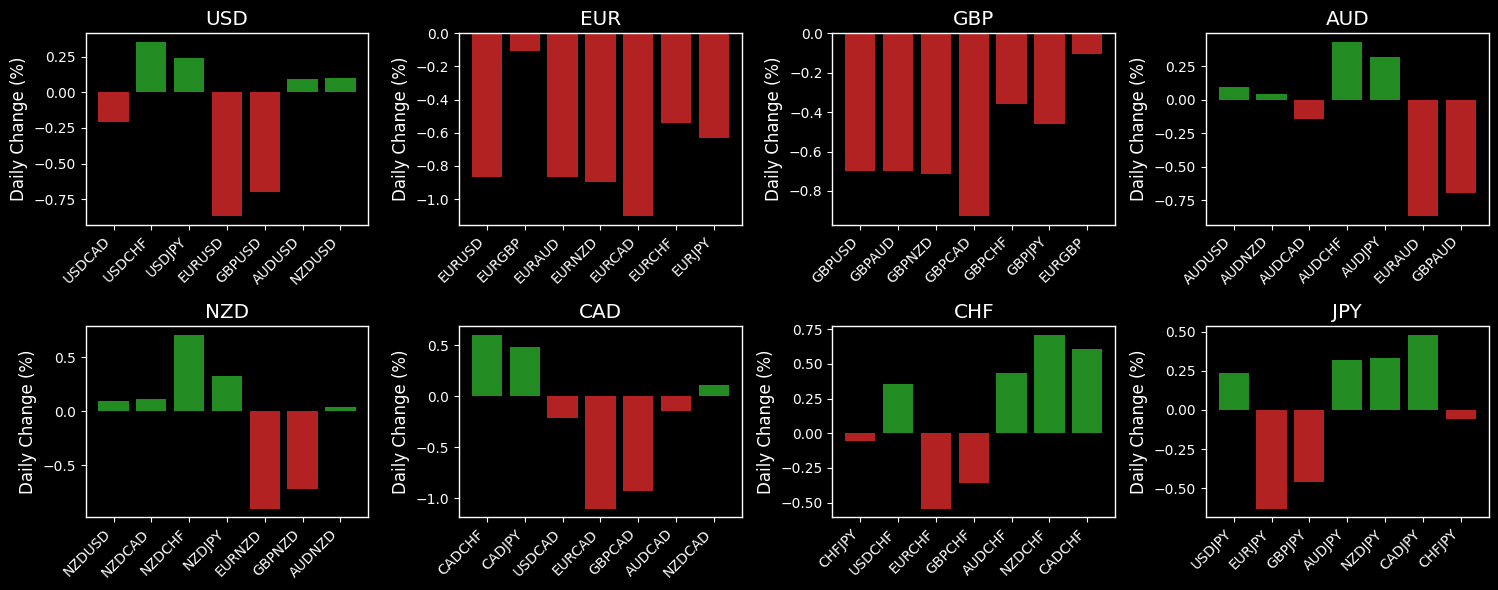

True

In [9]:
import MetaTrader5 as mt5
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# set the style of the plots
plt.style.use('dark_background')

# Function to add a subplot for each currency
def add_subplot(ax, df, currency):
    colors = ['#228B22' if change > 0 else '#b22222' for change in df['Daily Change (%)']]
    bars = ax.bar(df['Symbol'], df['Daily Change (%)'], color=colors)
    ax.set_title(currency)

    # Set the x-tick labels with FixedLocator
    ax.xaxis.set_major_locator(plt.FixedLocator(np.arange(len(df['Symbol']))))
    ax.set_xticklabels(df['Symbol'], rotation=45, ha='right')
    # do not show grid lines
    ax.grid(False)
    ax.set_ylabel('Daily Change (%)')


# Initialize MT5 connection
if not mt5.initialize():
    print("initialize() failed, error code =", mt5.last_error())
    quit()

# Your dictionary of currency majors
currency_majors = {
    "USD": ["USDCAD", "USDCHF", "USDJPY", "EURUSD", "GBPUSD", "AUDUSD", "NZDUSD"],
    "EUR": ["EURUSD", "EURGBP", "EURAUD", "EURNZD", "EURCAD", "EURCHF", "EURJPY"],
    "GBP": ["GBPUSD", "GBPAUD", "GBPNZD", "GBPCAD", "GBPCHF", "GBPJPY", "EURGBP"],
    "AUD": ["AUDUSD", "AUDNZD", "AUDCAD", "AUDCHF", "AUDJPY", "EURAUD", "GBPAUD"],
    "NZD": ["NZDUSD", "NZDCAD", "NZDCHF", "NZDJPY", "EURNZD", "GBPNZD", "AUDNZD"],
    "CAD": ["CADCHF", "CADJPY", "USDCAD", "EURCAD", "GBPCAD", "AUDCAD", "NZDCAD"],
    "CHF": ["CHFJPY", "USDCHF", "EURCHF", "GBPCHF", "AUDCHF", "NZDCHF", "CADCHF"],
    "JPY": ["USDJPY", "EURJPY", "GBPJPY", "AUDJPY", "NZDJPY", "CADJPY", "CHFJPY"]
}
# Prepare to create subplots
num_currencies = len(currency_majors)
rows = int(num_currencies ** 0.5)
cols = (num_currencies // rows) + (num_currencies % rows > 0)
fig, axs = plt.subplots(rows, cols, figsize=(15, 6))
axs = axs.flatten()  # Flatten the array for easy iteration

# Iterate through all currency majors and add subplots
for idx, (currency, majors) in enumerate(currency_majors.items()):
    data = []

    for symbol in majors:
        # Get current price
        current_price = mt5.symbol_info_tick(symbol).ask

        # Get the opening price for the current day
        rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_D1, 0, 1)
        
        if rates is not None and len(rates) > 0:
            open_price = rates[0][1]  # Open price of the current day
            daily_change = (current_price - open_price) / open_price * 100
            data.append([symbol, daily_change])
        else:
            print(f"Could not retrieve data for {symbol}")

    # Create DataFrame and add subplot
    df = pd.DataFrame(data, columns=['Symbol', 'Daily Change (%)'])
    add_subplot(axs[idx], df, currency)

# Adjust layout
plt.tight_layout()
plt.show()

# shut down connection to the MetaTrader 5 terminal
print("Shutting down connection to MT5...")
mt5.shutdown()

## Conclusion

This workflow provides a clear and efficient method for forex market analysis, leveraging the power of MetaTrader 5 and Python's data visualization libraries.